# Imports

This notebook is used to build the images, charts and graphs in the presentation.

In [10]:
import numpy as np
import skgstat as skg
skg.plotting.backend('plotly')
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

# Overview 

First the Geostatistical software image

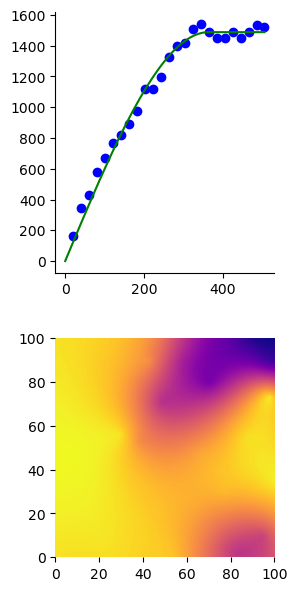

In [11]:
# get the pancake data
coords, vals = skg.data.pancake(N=500).get('sample')
vario = skg.Variogram(coords, vals, normalize=False, maxlag=0.75, n_lags=25)

x = np.linspace(0, vario.bins[-1], 100)
y = vario.fitted_model(x)

krige = vario.to_gs_krige()
field, ss = krige.structured((range(100), range(100)), return_var=True)


fig, axes = plt.subplots(2, 1, figsize=(3, 6.2))
axes[0].plot(vario.bins, vario.experimental, 'bo')
axes[0].plot(x, y, '-g')
axes[1].imshow(field, origin='lower', extent=(0, 100, 0, 100), cmap='plasma')

# remove all spines and axes
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[1].spines['bottom'].set_visible(False)
plt.tight_layout()
fig.savefig('public/img/geostatistical_software.png')

Then, an image illustrating the uncertainty package

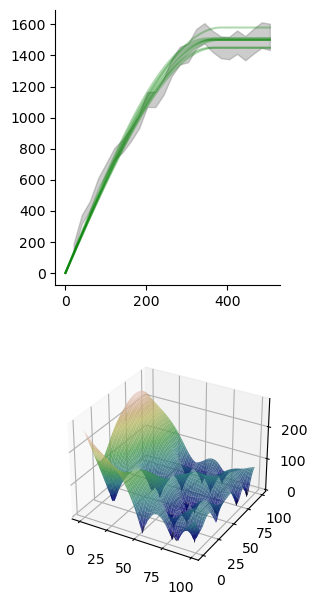

In [6]:
# Make up a random uncertainty band of about 150 units
np.random.seed(42)
lb = vario.experimental - np.random.normal([i *2.5 + 25 for i in range(len(vario.experimental))], scale=0.5)
np.random.seed(44)
ub = vario.experimental + np.random.normal([i *2.5 + 25 for i in range(len(vario.experimental))], scale=0.5)

fig = plt.figure(figsize=(3, 6.2))
ax1 = fig.add_subplot(211)
ax2  = fig.add_subplot(212, projection='3d')

#fig, axes = plt.subplots(2, 1, figsize=(4, 8))
ax1.fill_between(vario.bins, lb, ub, color='gray', alpha=0.4)

# put a few models through the area
x = np.linspace(0, vario.bins[-1], 100)
for r in np.arange(350, 390, 5):
    np.random.seed(r)
    y = skg.models.spherical(x, r, np.random.choice([1450,1490, 1500, 1510, 1550, 1580], 1))
    ax1.plot(x, y, '-g', alpha=0.3)

# create a meshgrid for the field
X, Y = np.meshgrid(range(100), range(100))
ax2.plot_surface(X, Y, ss, cmap='gist_earth', alpha=0.8)

# remove top and right spines
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# remove the spines from the 3d plot
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# save
plt.tight_layout()
fig.savefig('public/img/geostatistical_uncertainty.png')

In [9]:
# fit a gaussian, spheircal and exponential model
vario.model = 'gaussian'
y_gaus = vario.fitted_model(x)
p_gaus = vario.parameters

vario.model = 'exponential'
y_exp = vario.fitted_model(x)
p_exp = vario.parameters

vario.model = 'spherical'
y_sph = vario.fitted_model(x)
p_sph = vario.parameters

# print the vario bins and experimental values to a json file
import json
with open('src/slides/data/vario.json', 'w') as f:
    json.dump({
        'bins': vario.bins.round(1).tolist(),
        'experimental': vario.experimental.round(1).tolist(),
        'modelX': x.round(1).tolist(),
        'modelGauss': y_gaus.round(1).tolist(),
        'modelExp': y_exp.round(1).tolist(),
        'modelSph': y_sph.round(1).tolist(),
        'paramsGauss': p_gaus,
        'paramsExp': p_exp,
        'paramsSph': p_sph,
    }, f, indent=4)

# generate pre-defined uncertainty bounds

In [37]:
from collections import defaultdict
import json
from skgstat_uncertainty.processor.propagation import conf_interval_from_sample_std, kfold_residual_bootstrap, mc_absolute_observation_uncertainty

# result dict
data = defaultdict(lambda: {})

# put parameter here
CL = 0.95
N = [30, 50, 100, 300]

# go for each sample size
for n in N:
    # create a new variogram
    coords, vals = skg.data.pancake(N=n, seed=42).get('sample')
    v = skg.Variogram(coords, vals, normalize=False, maxlag=0.6, n_lags=10 if n < 100 else 15)

    data[f"{n}"]['bins'] = v.bins.tolist()

    # std z-score intervals
    intv_z = conf_interval_from_sample_std(v, CL)

    # k-fold
    intv_k = kfold_residual_bootstrap(v, k = 5 if n < 100 else 7, seed=42, q=[int((1 - CL) * 100), int(CL * 100)])

    # mc absolute observation uncertainty
    res = list(mc_absolute_observation_uncertainty(v, sigma=10, iterations=50, seed=42, sigma_type='precision'))[-1]
    intv_mc = np.column_stack((np.nanpercentile(res, (1 - CL) * 100, axis=0), np.nanpercentile(res, CL * 100, axis=0)))

    # add
    data[f"{n}"]['z-score'] = intv_z
    data[f"{n}"]['k-fold'] = intv_k
    data[f"{n}"]['mc'] = intv_mc.tolist()

# write results
with open('src/slides/data/uncertainty.json', 'w') as f:
    json.dump(data, f, indent=4)

## Add some models

In [51]:
from skgstat import models

# use N = 100 and method = 'k-fold
bins = data['100']['bins']
intv  = data['100']['k-fold']
x = np.linspace(0, bins[-1], 100)



# plot using plotly
import plotly.graph_objects as go
fig = go.Figure([
    go.Scatter(x=bins, y=[_[0] for _ in intv], mode='lines', showlegend=False, fill='none', line=dict(color='gray', width=0.5)),
    go.Scatter(x=bins, y=[_[1] for _ in intv], mode='lines', showlegend=False, fill='tonexty', line=dict(color='gray', width=0.5)),
])

model = 'gaussian'
model_func = getattr(models, model)
y = model_func(x, 340, 1500, 200)

fig.add_trace(go.Scatter(x=x, y=y, mode='lines', name='Spherical Model', line=dict(color='green', width=2)))
fig

In [52]:
# read existing data
import json
import os

if os.path.exists('src/slides/data/uncertain_models.json'):
    with open('src/slides/data/uncertain_models.json', 'r') as f:
        sav = json.load(f)
else:
    sav = {'x': x.tolist()}

# add new data
if 'models' in sav:
    sav['models'].append(y.tolist())
else:
    sav['models'] = [y.tolist()]

# save back
with open('src/slides/data/uncertain_models.json', 'w') as f:
    json.dump(sav, f, indent=4)

# image samples

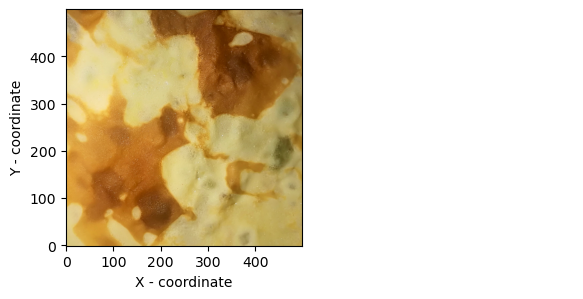

In [88]:
import skgstat as skg
import numpy as np
import matplotlib.pyplot as plt

# get the pancake data
r = skg.data.pancake_field(0).get('sample') 
g = skg.data.pancake_field(1).get('sample')
b = skg.data.pancake_field(2).get('sample')

rgb = np.stack([r, g, b], axis=-1)

fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax2.axis('off')
ax.set_xlabel('X - coordinate')
ax.set_ylabel('Y - coordinate')
ax.imshow(rgb, origin='lower')
plt.tight_layout()
fig.savefig('public/img/pancake_field_rgb.png')

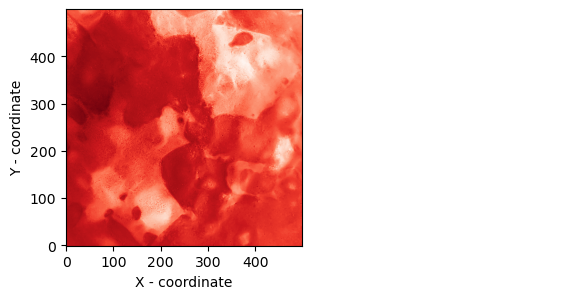

In [87]:
fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax2.axis('off')
ax.imshow(r, cmap='Reds', origin='lower')
ax.set_xlabel('X - coordinate')
ax.set_ylabel('Y - coordinate')
plt.tight_layout()
fig.savefig('public/img/pancake_field_r.png')

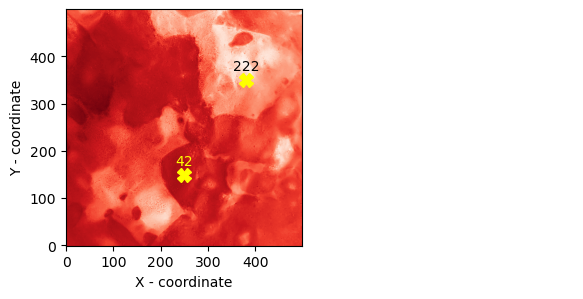

In [89]:
fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax2.axis('off')

ax.imshow(r, cmap='Reds', origin='lower')
ax.set_xlabel('X - coordinate')
ax.set_ylabel('Y - coordinate')

# plot two yellow crosses
ax.plot([250, 380], [150, 350], color='yellow', marker='X', linestyle='None', markersize=10)

# add text labels above the crosses
ax.text(250, 150+28, '42', color='yellow', fontsize=10, ha='center', va='center')
ax.text(380, 350+28, '222', color='black', fontsize=10, ha='center', va='center')

plt.tight_layout()
fig.savefig('public/img/pancake_field_sample.png')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import glob
from itertools import combinations

# sample size
N = 8 

# pre generate the random samples
np.random.seed(42)
xx =  np.random.randint(25, 475, N * 2)
yy =  np.random.randint(25, 475, N * 2)

# make points
points = list(zip(xx, yy))
all_p = list(combinations(points, 2))

# create a GIF of the images
frames = []
all_diffs = []
all_dist = []

#for i,j in zip(range(0, N * 2, 2), range(1, N * 2, 2)):
for i, (p1, p2) in enumerate(all_p):
    # get the two pixel values
    v1 = int(r[p1])
    v2 = int(r[p2])

    # get the differences
    diff = np.abs(v1 - v2)
    all_diffs.append(diff)

    # get the distance
    dist = np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)
    all_dist.append(dist)

    # create a new image for each frame
    fig = plt.figure(figsize=(6, 3))
    ax = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    # plot the image
    m = ax.imshow(r, cmap='Reds', origin='lower')
    ax.set_xlabel('X - coordinate')
    ax.set_ylabel('Y - coordinate')
    ax.plot(xx, yy, color='gray', alpha=0.8, marker='X', markersize=10, linestyle='None')
    ax.plot([p1[0], p2[0]], [p1[1], p2[1]], color='yellow', marker='X', linestyle='--', lw=0.8, markersize=10)
    
    # add text labels above the crosses
    ax.text(p1[0], p1[1] + 28, v1, color='yellow', fontsize=10, ha='center', va='center')
    ax.text(p2[0], p2[1] + 28, v2, color='yellow', fontsize=10, ha='center', va='center')
    
    # create the point cloud
    if i > 0:
        ax2.plot(all_dist[:-1], all_diffs[:-1], color='blue', marker='o', linestyle='None', markersize=5, alpha=0.5)
    ax2.plot(all_dist[-1], all_diffs[-1], color='yellow', marker='o', linestyle='None', markersize=7, alpha=1.0)
    ax2.set_xlabel('Separating distance')
    ax2.set_ylabel('Value difference')
    ax2.set_xlim(0, 450)
    ax2.set_ylim(0, 50)
    plt.tight_layout()
    fig.canvas.draw()

    width, height = fig.get_size_inches() * fig.get_dpi()
    img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    img = img.reshape(int(height), int(width), 3)
    img = Image.fromarray(img)

    # save the image as a frame of the GIF
    img.save(f'frame_{i+1}.png')
    frames.append(Image.open(f'frame_{i+1}.png'))

# save the frames as a GIF
frames[0].save('public/img/pancake_animation.gif', format='GIF', append_images=frames[1:], save_all=True, duration=200, loop=0)

# remove the frames_*.png files
for file in glob.glob('frame_*.png'):
    os.remove(file)

# Parallel Coordinates

In [1]:
# imports
from skgstat_uncertainty.api import API
from skgstat_uncertainty.components.plotting import metric_parcats, base_conf_graph, make_subplots

api = API(data_path='/home/mirko/Dropbox/python/uncertain_geostatistics/data', db_name='u_Mirko.db')

pan = api.get_upload_data(id=2)

params = pan.variograms[0]
conf = params.conf_intervals[0]


In [2]:
from plotly.io import write_json

#fig = base_conf_graph(params, conf, fig)
fig = metric_parcats(conf.models, metrics=['rmse', 'dic', 'cv'], percentiles=[10, 20, 40, 60, 80, 90])

with open('src/slides/data/metric_parcat.json', 'w') as f:
    write_json(fig, f, pretty=True)

fig

In [6]:
from skgstat import models
from numpy import linspace
import plotly.graph_objects as go

# generate the x data
x  = linspace(0,  params.variogram.bins[-1], 100)

fig = base_conf_graph(params, conf)

for i, m in enumerate(conf.models):
    name = m.parameters['model_params']['model']
    par = m.parameters['model_params']
    mod_func = getattr(models, name)

    # call
    if name in ('stable', 'matern'):
        y = mod_func(x, par['range'], par['sill'], par['shape'], par['nugget'])
    else:
        y = mod_func(x, par['range'], par['sill'], par['nugget'])

    # add to the figure
    fig.add_trace(go.Scatter(x=x, y=y, mode='lines', line_color='green', line_width=1, opacity=0.5, showlegend=i == 0, name='Theoretical models'))

# save the figure
with open('src/slides/data/theoretical_models.json', 'w') as f:
    write_json(fig, f, pretty=True)

fig

# Soil Moisture data

In [11]:
import pandas as pd
from tqdm.notebook import tqdm

In [99]:
# load the data
store = pd.HDFStore('./dev_data/daily_agg.hd5')
m30 = store.get('m30')
store.close()

positions = pd.read_csv('./dev_data/positions.csv')

In [175]:
# filter out all data where the mean is > 0.5
m30 = m30.loc[:, m30.mean() < 0.4]

In [176]:
WIDTH = 30

# use only a subset of the data
sam = m30['20130401':'20140101']

# get only the positions
pos = positions.set_index('d').loc[:, ('x', 'y')].copy()

# container for results
slices = []

for i in tqdm(range(1, sam.shape[0] - WIDTH)):
    vals = sam.iloc[i:i + WIDTH, :].mean()
    vals.name = 'moisture'

    # merge and save
    df = pd.merge(pos, vals, left_index=True, right_index=True).dropna(how='any', axis='index')
    slices.append(df.copy())

print(f'Generated {len(slices)} slices')

  0%|          | 0/245 [00:00<?, ?it/s]

Generated 245 slices


In [177]:
# build variograms for all
from skgstat import Variogram

# some static parameters
n_lags = 8
maxlag = 'median'
model = 'stable'
bin_func = 'uniform'

# container for variograms
varios = []

for df in tqdm(slices):
    vario = Variogram(df[['x', 'y']].values, df.moisture.values, n_lags=n_lags, use_nugget=True, maxlag=maxlag, normalize=False, model=model, bin_func=bin_func)
    varios.append(vario)

print(f'Generated {len(varios)} variograms')

  0%|          | 0/245 [00:00<?, ?it/s]

Generated 245 variograms


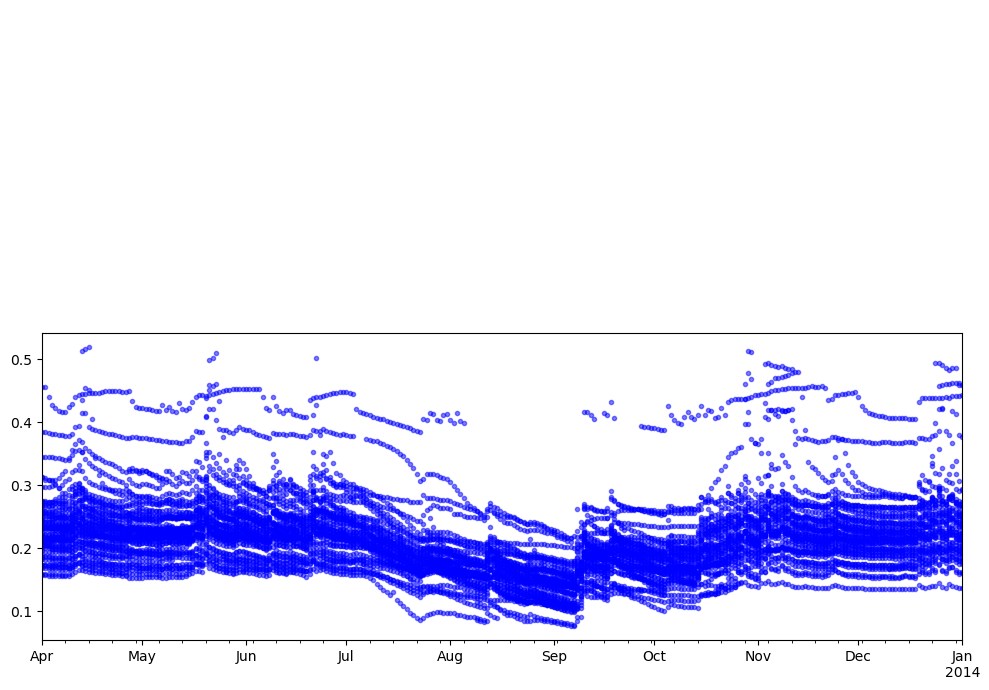

In [185]:
# STEP 1
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 7))

# create a grid with two rows and two columns
ax1 = plt.subplot2grid((2, 2), (0, 0))
ax2 = plt.subplot2grid((2, 2), (0, 1))
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)

# plot on the top left subplot
ax1.axis('off')

# plot on the top right subplot
ax2.axis('off')

# plot on the bottom subplot
sam.plot(legend=False, c='blue', alpha=0.5, ax=ax3, linestyle='None', marker='o', markersize=3)
plt.tight_layout()
fig.savefig('public/img/moisture_cluster_step1.png')

In [186]:
# STEP 2

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.dates as mdates
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm

images = []

for i, vario in tqdm(enumerate(varios), total=len(varios)):
    fig = plt.figure(figsize=(10, 7))

    # create a grid with two rows and two columns
    ax1 = plt.subplot2grid((2, 2), (0, 0))
    ax2 = plt.subplot2grid((2, 2), (0, 1))
    ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)

    # plot on the top left subplot
    #ax1.axis('off')
    # resolve to 100 values
    for v in varios[:i]:
        x = np.linspace(0, v.bins[-1], 100)
        y = v.fitted_model(x)
        ax1.plot(x, y, '-g', alpha=0.1)
    x = np.linspace(0, vario.bins[-1], 100)
    y = vario.fitted_model(x)
    ax1.plot(x, y, '-g')

    # plot on the top right subplot
    ax2.axis('off')

    # plot on the bottom subplot
    sam.plot(legend=False, c='blue', alpha=0.5, ax=ax3, linestyle='None', marker='o', markersize=3)

    # add an orange box to ax3
    rect = patches.Rectangle((
        mdates.date2num(sam.index[i].to_pydatetime()), 
        ax3.get_ylim()[0]), 
        WIDTH, 
        ax3.get_ylim()[1] - ax3.get_ylim()[0], 
        linewidth=3, 
        edgecolor=(1, 0.5, 0, 1), 
        facecolor=(1, 0.5, 0, 0.3)
    )
    ax3.add_patch(rect)

    plt.tight_layout()

    # save the figure as an image
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    images.append(Image.fromarray(image))
    plt.close()

    #if i > 20:
    #    break

# save the images as a GIF
images[0].save('public/img/moisture_cluster_step2.gif', save_all=True, append_images=images[1:], duration=100, loop=0)

  0%|          | 0/245 [00:00<?, ?it/s]

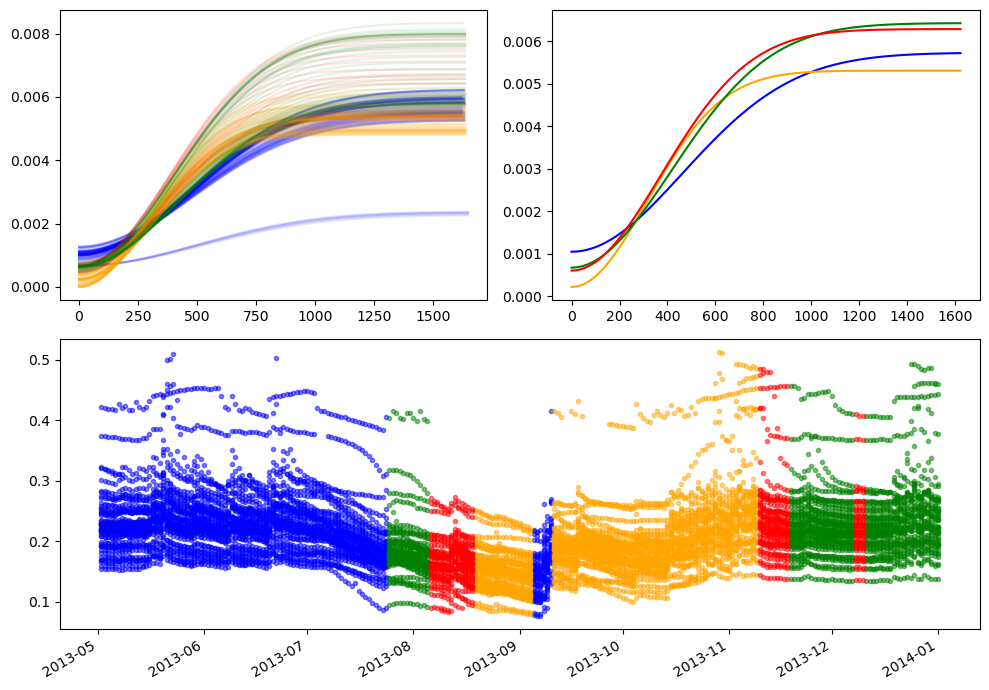

In [187]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import MeanShift, KMeans
from skgstat.models import stable

# do the clustering
data = np.column_stack([np.array(v.parameters) for v in varios])
#data = np.column_stack([np.array(v.experimental) for v in varios])
ms = MeanShift()
#ms = KMeans(n_clusters=3)
ms.fit_predict(data.T)

# get all unique labels and add a color for each to a lookup dict
lookup = {0: 'blue', 1: 'orange', 2: 'green', 3: 'red'}

# build the figure
fig = plt.figure(figsize=(10, 7))

# create a grid with two rows and two columns
ax1 = plt.subplot2grid((2, 2), (0, 0))
ax2 = plt.subplot2grid((2, 2), (0, 1))
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)

# plot on the top left subplot
#ax1.axis('off')
# resolve to 100 values
for v, lab in zip(varios, ms.labels_):
    x = np.linspace(0, v.bins[-1], 100)
    y = v.fitted_model(x)
    ax1.plot(x, y, alpha=0.1, c=lookup.get(lab, 'gray'))
    #ax1.plot(v.bins, v.experimental, c=lookup.get(lab, 'gray'), alpha=0.1)

# plot on the top right subplot
for i, pars in enumerate(ms.cluster_centers_):
    x = np.linspace(0, varios[0].bins[-1], 100)
    y = stable(x, *pars)
    ax2.plot(x, y, c=lookup.get(i, 'gray'))



# plot on the bottom subplot
for lab in np.unique(ms.labels_):
    mask = ms.labels_ == lab
    sam[WIDTH + 1:].iloc[mask, :].plot(legend=False, c=lookup.get(lab, 'gray'), alpha=0.5, ax=ax3, linestyle='none', marker='o', markersize=3)
#sam.plot(legend=False, c='blue', alpha=0.5, ax=ax3)


plt.tight_layout()
fig.savefig('public/img/moisture_cluster_step3.png')

# Cluster graphs

In [1]:
import json

CLUSTER = 'g'

# load
with open(f'./dev_data/vario_graph_{CLUSTER}.json') as f:
    data = json.load(f)

print(f"Loaded {len(data['nodes'])} nodes and {len(data['links'])} links.")

Loaded 54 nodes and 502 links.


In [2]:
# rename all distance values to 'separating' and calculate min and max along the way
minD = 99999
maxD = -1
minR = 99999
maxR = -1

for link in data['links']:
    val = link['distance']
    res = link['residual']

    link['separating'] = val
    if minD > val:
        minD = val
    if maxD < val:
        maxD = val
    if minR > res:
        minR = res
    if maxR < res:
        maxR = res

# in a second loop normalize the separating and residual values to a range of 5 to 100
for link in data['links']:
    link['separating_norm'] = 5 + (link['separating'] - minD) / (maxD - minD) * 95
    link['residual_norm'] = 5 + (link['residual'] - minR) / (maxR - minR) * 95

    # and finally set residual as distance
    link['distance'] = link['residual_norm']

# save
with open(f'./src/slides/data/cluster_{CLUSTER}.json', 'w') as f:
    json.dump(data, f, indent=4)